In [1]:
import os
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, datasets
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Using device: mps


In [2]:
# -------------------------------
# Custom Dataset and DataLoader
# -------------------------------

# Custom dataset that performs face detection and cropping
class FaceCroppedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = image[y:y+h, x:x+w]
        else:
            face = image  # fallback if no face detected

        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = Image.fromarray(face)

        if self.transform:
            face = self.transform(face)

        return face, label

# Create data loaders with face detection + augmentation
def get_dataloaders(data_dir, image_size=(224, 224), batch_size=32):
    # Data augmentation for training set
    train_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.RandomResizedCrop(image_size[0], scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Transform for test set
    test_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load datasets using FaceCroppedDataset
    train_dataset = FaceCroppedDataset(os.path.join(data_dir, "train"), transform=train_transform)
    test_dataset = FaceCroppedDataset(os.path.join(data_dir, "test"), transform=test_transform)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset.dataset.classes, test_transform



In [3]:
# -------------------------------
# Model Definition: TunedResNet18
# -------------------------------

class TunedResNet18(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_rate):
        super(TunedResNet18, self).__init__()
        # Load pre-trained ResNet18 model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        # Replace the final fc layer with a custom classifier
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)



In [4]:
# -------------------------------
# Training and Evaluation Functions
# -------------------------------

def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    best_val_acc = 0.0
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # Evaluate on the validation set after each epoch
        val_acc = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
    return best_val_acc

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return correct / total



In [5]:
# -------------------------------
# Hyperparameter Tuning Settings
# -------------------------------

# Define hyperparameters for grid search
hidden_sizes = [256, 512]          # Hidden layer sizes in the custom classifier
dropout_rates = [0.3, 0.4, 0.5]      # Dropout rates to test
learning_rates = [0.001, 0.0001]     # Learning rates to test
optimizers_choice = ['adam', 'sgd']  # Optimizer choices

# Specify data directory for facial emotion recognition datasets (FER-2013 & RAF-DB)
data_dir = "FER-2013"

# Create data loaders using our custom function
train_loader, val_loader, classes, _ = get_dataloaders(data_dir, image_size=(224, 224), batch_size=32)

# Ensure we have 6 classes (e.g., "angry", "fear", "happy", "natural", "sad", "surprise")
num_classes = len(classes)
print("Classes:", classes)

# Use the MPS backend if available (for Apple Silicon), else fallback to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Using device: mps


In [6]:
# Create directory to save models if it doesn't exist
models_path = "Models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [7]:
# Define the custom model that modifies ResNet18's classifier
class TunedResNet18(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_rate):
        super(TunedResNet18, self).__init__()
        # Load pre-trained ResNet18 model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        # Replace the final fc layer with a custom classifier
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

# Training function for one configuration
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    best_val_acc = 0.0
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # Evaluate on the validation set after each epoch
        val_acc = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
    return best_val_acc

# Evaluation function to compute accuracy on the validation set
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return correct / total

In [8]:
# -------------------------------
# Hyperparameter Tuning Loop
# -------------------------------

results = []
best_overall_val_acc = 0.0
best_model_state = None
best_params = None
num_epochs = 5  # Increase as needed for robust experiments

for hidden_size, dropout_rate, lr, opt_name in itertools.product(
    hidden_sizes, dropout_rates, learning_rates, optimizers_choice):
    
    print(f"\nTesting configuration: hidden_size={hidden_size}, dropout_rate={dropout_rate}, "
          f"lr={lr}, optimizer={opt_name}")
    
    # Initialize the model with the current hyperparameters
    model = TunedResNet18(num_classes=num_classes, hidden_size=hidden_size, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Choose the optimizer based on the current configuration
    if opt_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Train the model and get the best validation accuracy for this configuration
    val_acc = train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, device)
    print(f"Configuration Validation Accuracy: {val_acc:.4f}")
    
    # Save the current configuration and its result
    results.append({
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate,
        "learning_rate": lr,
        "optimizer": opt_name,
        "accuracy": val_acc
    })
    
    # Update the best overall model if the current configuration is better
    if val_acc > best_overall_val_acc:
        best_overall_val_acc = val_acc
        best_params = {
            "hidden_size": hidden_size,
            "dropout_rate": dropout_rate,
            "learning_rate": lr,
            "optimizer": opt_name
        }
        best_model_state = model.state_dict()

# Save the best model to the specified path
if best_model_state is not None:
    filename = f"resnet18_best_hs{best_params['hidden_size']}_drop{best_params['dropout_rate']}_lr{best_params['learning_rate']}_{best_params['optimizer']}.pt"
    filepath = os.path.join(models_path, filename)
    torch.save(best_model_state, filepath)
    print(f"\nBest model saved to: {filepath}")




Testing configuration: hidden_size=256, dropout_rate=0.3, lr=0.001, optimizer=adam
Epoch 1/5, Validation Accuracy: 0.5432
Epoch 2/5, Validation Accuracy: 0.5906
Epoch 3/5, Validation Accuracy: 0.5950
Epoch 4/5, Validation Accuracy: 0.6184
Epoch 5/5, Validation Accuracy: 0.6189
Configuration Validation Accuracy: 0.6189

Testing configuration: hidden_size=256, dropout_rate=0.3, lr=0.001, optimizer=sgd
Epoch 1/5, Validation Accuracy: 0.3035
Epoch 2/5, Validation Accuracy: 0.4239
Epoch 3/5, Validation Accuracy: 0.4849
Epoch 4/5, Validation Accuracy: 0.5073
Epoch 5/5, Validation Accuracy: 0.5183
Configuration Validation Accuracy: 0.5183

Testing configuration: hidden_size=256, dropout_rate=0.3, lr=0.0001, optimizer=adam
Epoch 1/5, Validation Accuracy: 0.6284
Epoch 2/5, Validation Accuracy: 0.6581
Epoch 3/5, Validation Accuracy: 0.6649
Epoch 4/5, Validation Accuracy: 0.6697
Epoch 5/5, Validation Accuracy: 0.6791
Configuration Validation Accuracy: 0.6791

Testing configuration: hidden_size=2


All Hyperparameter Tuning Results:
    hidden_size  dropout_rate  learning_rate optimizer  accuracy
0           256           0.3         0.0010      adam  0.618933
1           256           0.3         0.0010       sgd  0.518325
2           256           0.3         0.0001      adam  0.679072
3           256           0.3         0.0001       sgd  0.263337
4           256           0.4         0.0010      adam  0.615254
5           256           0.4         0.0010       sgd  0.520023
6           256           0.4         0.0001      adam  0.675110
7           256           0.4         0.0001       sgd  0.265318
8           256           0.5         0.0010      adam  0.614405
9           256           0.5         0.0010       sgd  0.522711
10          256           0.5         0.0001      adam  0.670723
11          256           0.5         0.0001       sgd  0.267723
12          512           0.3         0.0010      adam  0.627706
13          512           0.3         0.0010       sgd

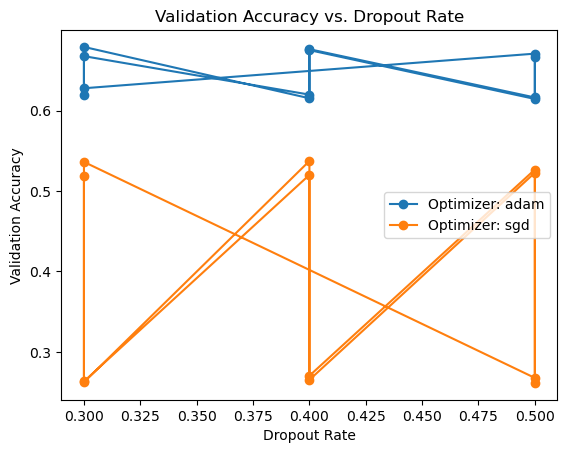

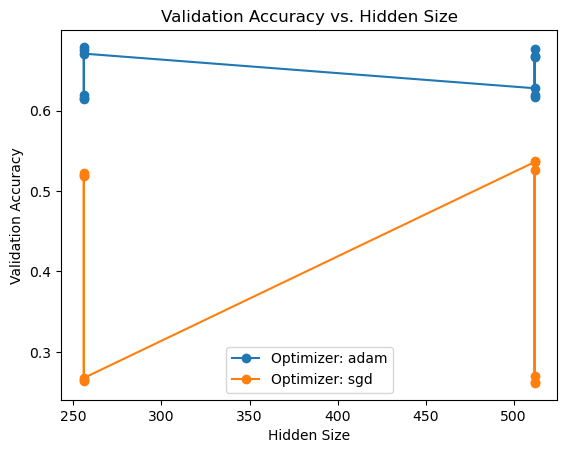

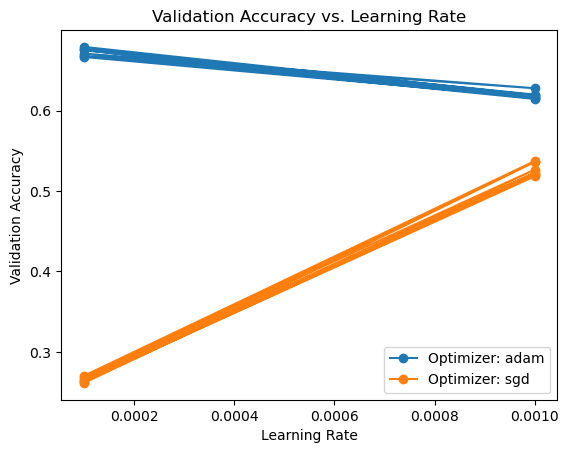

In [9]:
# -------------------------------
# Plotting Hyperparameter Tuning Results
# -------------------------------

results_df = pd.DataFrame(results)
print("\nAll Hyperparameter Tuning Results:")
print(results_df)

# Plot: Accuracy vs. Dropout Rate
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['dropout_rate'], subset['accuracy'], marker='o', linestyle='-', label=f"Optimizer: {opt}")
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Dropout Rate')
plt.legend()
plt.show()

# Plot: Accuracy vs. Hidden Size
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['hidden_size'], subset['accuracy'], marker='o', linestyle='-', label=f"Optimizer: {opt}")
plt.xlabel('Hidden Size')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Hidden Size')
plt.legend()
plt.show()

# Plot: Accuracy vs. Learning Rate
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['learning_rate'], subset['accuracy'], marker='o', linestyle='-', label=f"Optimizer: {opt}")
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Learning Rate')
plt.legend()
plt.show()

In [ ]:
# Specify data directory for facial emotion recognition datasets (FER-2013 & RAF-DB)
data_dir = "RAF-DB"

# Create data loaders using our custom function
train_loader, val_loader, classes, _ = get_dataloaders(data_dir, image_size=(224, 224), batch_size=32)

# Ensure we have 6 classes (e.g., "angry", "fear", "happy", "natural", "sad", "surprise")
num_classes = len(classes)
print("Classes:", classes)

In [ ]:
# -------------------------------
# Hyperparameter Tuning Loop
# -------------------------------

results = []
best_overall_val_acc = 0.0
best_model_state = None
best_params = None
num_epochs = 5  # Increase as needed for robust experiments

for hidden_size, dropout_rate, lr, opt_name in itertools.product(
    hidden_sizes, dropout_rates, learning_rates, optimizers_choice):
    
    print(f"\nTesting configuration: hidden_size={hidden_size}, dropout_rate={dropout_rate}, "
          f"lr={lr}, optimizer={opt_name}")
    
    # Initialize the model with the current hyperparameters
    model = TunedResNet18(num_classes=num_classes, hidden_size=hidden_size, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Choose the optimizer based on the current configuration
    if opt_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Train the model and get the best validation accuracy for this configuration
    val_acc = train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, device)
    print(f"Configuration Validation Accuracy: {val_acc:.4f}")
    
    # Save the current configuration and its result
    results.append({
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate,
        "learning_rate": lr,
        "optimizer": opt_name,
        "accuracy": val_acc
    })
    
    # Update the best overall model if the current configuration is better
    if val_acc > best_overall_val_acc:
        best_overall_val_acc = val_acc
        best_params = {
            "hidden_size": hidden_size,
            "dropout_rate": dropout_rate,
            "learning_rate": lr,
            "optimizer": opt_name
        }
        best_model_state = model.state_dict()

# Save the best model to the specified path
if best_model_state is not None:
    filename = f"resnet18_RAF_best_hs{best_params['hidden_size']}_drop{best_params['dropout_rate']}_lr{best_params['learning_rate']}_{best_params['optimizer']}.pt"
    filepath = os.path.join(models_path, filename)
    torch.save(best_model_state, filepath)
    print(f"\nBest model saved to: {filepath}")

In [ ]:
# -------------------------------
# Plotting Hyperparameter Tuning Results
# -------------------------------

results_df = pd.DataFrame(results)
print("\nAll Hyperparameter Tuning Results:")
print(results_df)

# Plot: Accuracy vs. Dropout Rate
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['dropout_rate'], subset['accuracy'], marker='o', linestyle='-', label=f"Optimizer: {opt}")
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Dropout Rate')
plt.legend()
plt.show()

# Plot: Accuracy vs. Hidden Size
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['hidden_size'], subset['accuracy'], marker='o', linestyle='-', label=f"Optimizer: {opt}")
plt.xlabel('Hidden Size')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Hidden Size')
plt.legend()
plt.show()

# Plot: Accuracy vs. Learning Rate
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['learning_rate'], subset['accuracy'], marker='o', linestyle='-', label=f"Optimizer: {opt}")
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Learning Rate')
plt.legend()
plt.show()